# Purpose

This notebook focuses on the Kaggle Challenge : [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started). The defined goal is to predict which of the tweets have content that is related to a real disaster and which do not. 


# Setup

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


import spacy
#python -m spacy download en_core_web_sm
import en_core_web_lg as mod
nlp = mod.load()

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.vocab import Vocab


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers

from re import search
import re
from IPython.display import display

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

def code_section_break(title):
    print('--------------------------------------------------------------------------------------------------')
    print(title)
    print('--------------------------------------------------------------------------------------------------')

/kaggle/input/american-sports/American_Sports.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
#Read in Data
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")




# Preliminary Exploration

The training dataset contains the following information in the columns :
> 1. id - a unique identifier for each tweet
>1. text - the text of the tweet
>1. location - the location the tweet was sent from (may be blank)
>1. keyword - a particular keyword from the tweet (may be blank)
>1. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


and has 7613 entries.

Looking at the keywords, they look semantically linked to disaster. Both disaster and non-disaster labeled items have these words as keywords but they occur in different frequencies. However, the first several tweets contain these keywords, and yet have NaN in the keyword column. 

_improvement suggestions:_  
Data Visualization: 
1. Word clouds 
2. Word vs. Freq plot


In [4]:
code_section_break('Basic Visual Exploration')
pd.set_option('display.max_colwidth', 1)
#Visual Exploration
print(train_data.shape)
display(train_data.head(5))

#Label the keys
print(train_data.keys())
df=train_data
id_key=0
text_key=3
y_key=4

code_section_break(' unique keywords')

#collect the keywords
keywords_look=str(train_data.loc[train_data['target'] == 1].keyword.unique()).replace("'", "").replace('nan', " ")
print(keywords_look)
neg_keywords_look=str(train_data.loc[train_data['target'] == 0].keyword.unique()).replace("'", "").replace('nan', " ")
print(neg_keywords_look)

code_section_break('keyword frequencies')
print(train_data.loc[train_data["target"] == 1]["keyword"].value_counts()[0:10])
print(train_data.loc[train_data["target"] == 0]["keyword"].value_counts()[0:10])


--------------------------------------------------------------------------------------------------
Basic Visual Exploration
--------------------------------------------------------------------------------------------------
(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
--------------------------------------------------------------------------------------------------
 unique keywords
--------------------------------------------------------------------------------------------------
[  ablaze accident airplane%20accident ambulance annihilated
 annihilation apocalypse armageddon army arson arsonist
 attack attacked avalanche battle bioterror bioterrorism
 blaze blazing bleeding blew%20up blight blizzard blood
 bloody blown%20up body%20bag body%20bagging body%20bags bomb
 bombed bombing bridge%20collapse buildings%20burning
 buildings%20on%20fire burned burning burning%20buildings
 bush%20fires casualties casualty catastrophe catastrophic
 chemical%20emergency cliff%20fall collapse collapsed collide
 collided collision crash crashed crush crushed curfew
 cyclone damage danger dead death deaths debris deluge
 deluged demolish demolished demolition derail derailed
 derailment desolate de

# Pretreat the training data

There are duplicates in this dataset.Dropping all of them slightly reduces performance. Dropping true repeats and ambiguous peforms in the middle of dropping none and dropping all. 

_improvement suggestions:_  
Resolve the ambiguous labeling and drop only the true repeats

In [5]:
#Dropping out duplicates

#All duplicate tweets
# train_data =train_data.drop_duplicates(subset=['text'], keep=False)

# drop repeated tweets with the same truth and all tweets with truth discrepancies
duplicates=pd.concat(g for _, g in df.groupby("text") if len(g) > 1)
identicaltargetdrop=duplicates.drop_duplicates(subset=['text','target'], keep=False)
identicaltextdrop=identicaltargetdrop.drop_duplicates(subset=['text'], keep=False)

EVERY_dup=duplicates.id.unique()
sub1=identicaltargetdrop.id.unique()
sub2=identicaltextdrop.id.unique()

to_remove=list(EVERY_dup.copy())
for item in sub2:
    to_remove.remove(item)
to_remove=np.array(to_remove)

train_data=train_data[~train_data['id'].isin(to_remove)]

In [6]:
#individual text processing
# Remove all URLs, replace by URL
    
def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'URL',text)
    
def relabel_mention(text):
    at=re.compile(r'@')
    return at.sub(r'USRTAG ',text)
def remove_newline(text):
    at=re.compile(r'\n')
    return at.sub(r' ',text)
def replace_separators(text):
    at1=re.compile(r'ÛÒ')
    at2=re.compile(r'ÛÓ')
    at1.sub(r'***',text)
    return at2.sub(r'***',text)


#-------------------------------------------------------------

def df_txt_cleaner(text):
    text=remove_URL(text)
    text=relabel_mention(text)
    text=remove_newline(text)
    text=replace_separators(text)
    
    return text 
    

In [7]:
snippet_length=50
column_names=['text']
treated_sample=pd.DataFrame(columns=column_names)
treated_sample["text"]= train_data["text"][:snippet_length]
treated_sample["text_cleaner_results"]= train_data["text"][:snippet_length].apply(df_txt_cleaner)
display(treated_sample)


,text,text_cleaner_results
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California","13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas","#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas"
7,I'm on top of the hill and I can see a fire in the woods...,I'm on top of the hill and I can see a fire in the woods...
8,There's an emergency evacuation happening now in the building across the street,There's an emergency evacuation happening now in the building across the street
9,I'm afraid that the tornado is coming to our area...,I'm afraid that the tornado is coming to our area...


# Feature Extraction

Keywords are pulled from the text, and then the extracted keywords in the text are represented as a vector using a basis set of the keywords.


In [8]:
#dis = nlp("disaster")

def make_keywords(df,y_key):
    keyword_list=df.loc[df[df.keys()[y_key]] == 1].keyword.unique()
    keyword_str=str(keyword_list).replace("'", "").replace('nan', " ")[1:-1]
    return keyword_list,keyword_str

def collect_keywords(text,df,y_key):
    keyword_list= make_keywords(df,y_key)[0]
    keyword_collected=' '
    tokencounter=0

    doc = nlp(text)
    for token in doc:
        for keyword in keyword_list:
            if search('%20', str(keyword)):
                if tokencounter<len(doc)-1:
                    combi=token.lower_+'%20'+doc[tokencounter+1].lower_
                    if combi==keyword:
                         keyword_collected=keyword_collected+' '+str(keyword)
            elif search(str(keyword), token.lower_):
                keyword_collected=keyword_collected+' '+str(keyword)
        tokencounter+=1
    text=keyword_collected
    text.lower 
    return text

def collect_keywords_simplified(text,df,y_key):
    keyword_list= make_keywords(df,y_key)[0]
    keyword_collected=' '
    tokencounter=0

    doc = text.split()
    for token in doc:
        for keyword in keyword_list:
            if search('%20', str(keyword)):
                if tokencounter<len(doc)-1:
                    combi=token.lower()+'%20'+doc[tokencounter+1].lower()
                    if combi==keyword:
                         keyword_collected=keyword_collected+' '+str(keyword)
            elif search(str(keyword), token.lower()):
                keyword_collected=keyword_collected+' '+str(keyword)
        tokencounter+=1
    text=keyword_collected
    text.lower 
    return text

def ff_preproc(train_data,keywords): 
    #additional_words=str(' ')
    count_vect = CountVectorizer() 
#   feature_frame=count_vect.fit_transform(df['text']).copy()
    count_vect.fit([keywords])
    return count_vect
   
def feature_frame_creator_disastertweets(df,count_vect,train_data,y_key):
    cleaned_text=df["text"].apply(collect_keywords_simplified,args=(train_data,y_key))
    feature_frame=count_vect.transform(cleaned_text).copy()
    feature_frame_array=feature_frame.toarray()
    return feature_frame_array

In [9]:
snippet_length=30
keyword_list=make_keywords(train_data,y_key)[0]
keyword_str=make_keywords(train_data,y_key)[1]

print( keyword_list[1])

column_names=['extracted_keywords','text']
extract_sample=pd.DataFrame(columns=column_names)
extract_sample["text"]= train_data["text"][:snippet_length]
extract_sample["extracted_keywords"]= train_data["text"][:snippet_length].apply(collect_keywords,args=(train_data,y_key))
extract_sample["extracted_keywords_simplified"]= train_data["text"][:snippet_length].apply(collect_keywords_simplified,args=(train_data,y_key))
extract_sample["target"]=train_data["target"][:snippet_length]
pd.set_option('display.max_colwidth', 100)
extract_sample[['text','extracted_keywords','extracted_keywords_simplified']].head(snippet_length)

ablaze


,text,extracted_keywords,extracted_keywords_simplified
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,earthquake,earthquake
1,Forest fire near La Ronge Sask. Canada,forest%20fire fire,forest%20fire fire
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,evacuation,evacuation
3,"13,000 people receive #wildfires evacuation orders in California",fire wildfire evacuation,fire wildfire evacuation
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,smoke fire wildfire,smoke fire wildfire
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAf...,fire fire fire fire wildfire,fire fire fire fire wildfire
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",flood disaster flood flooding,flood disaster flood flooding
7,I'm on top of the hill and I can see a fire in the woods...,fire,fire
8,There's an emergency evacuation happening now in the building across the street,emergency evacuation,emergency evacuation
9,I'm afraid that the tornado is coming to our area...,tornado,tornado


In [10]:
#feature frame

# FF_creator=feature_frame_creator_disastertweets
# count_vect=ff_preproc(train_data)

FF_creator=feature_frame_creator_disastertweets
count_vect=ff_preproc(train_data,make_keywords(train_data,y_key)[1])


#labels
y_labels=df[df.keys()[y_key]].copy()

#train test split
#print(type(feature_frame_train))
X_train_pre, X_test_pre, y_train, y_test = train_test_split(df,y_labels, random_state=0)
X_train=FF_creator(X_train_pre,count_vect,train_data,y_key)
X_test=FF_creator(X_test_pre,count_vect,train_data,y_key)
# X_train=FF_creator(X_train_pre,count_vect)
# X_test=FF_creator(X_test_pre,count_vect)
input_shape = [X_train.shape[1]]

# Model Selection

An earlier version of the code used MultinomialNB() and there is not much improvement by implementing this neural network. The reccomended threshold for binary classification is 0.5 which gives the most correct identification, however the recall is better with a threshold of 0.1. 

Minimum Validation Loss: 0.5106
[[175 932]
 [ 28 769]]
944
0.9648682559598495
[[617 490]
 [119 678]]
1295
0.8506900878293601
[[785 322]
 [181 616]]
1401
0.7728983688833124
[[843 264]
 [228 569]]
1412
0.7139272271016311
[[944 163]
 [303 494]]
1438
0.6198243412797992
[[1038   69]
 [ 422  375]]
1413
0.47051442910915936
[[1070   37]
 [ 494  303]]
1373
0.38017565872020076
[[1094   13]
 [ 556  241]]
1335
0.30238393977415307
[[1103    4]
 [ 636  161]]
1264
0.20200752823086573


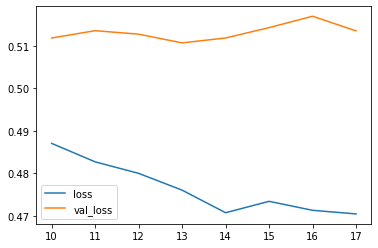

In [11]:
#select model
model= keras.Sequential([
    layers.Dense(150, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.Dense(150, activation='relu'),  
    layers.Dense(150, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
]) 

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
    verbose=0
)


# #score

# Start the plot at epoch 10
history_df = pd.DataFrame(history.history)
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));


for threshold in np.arange(.1,1,.1):
    matrix = confusion_matrix(y_test,(model.predict(X_test)>threshold).astype('int32'))
    print(matrix)
    print(matrix[0,0]+matrix[1,1])
    print(matrix[1,1]/(matrix[1,0]+matrix[1,1]))



# Predictions for submission

In [12]:
# #predict
y_predict=(model.predict(FF_creator(test_data,count_vect,train_data,y_key))>0.5).astype('int32')


# #output formating
sample_submission[df.keys()[y_key]]=y_predict

# print(output)
sample_submission.to_csv("submission.csv",index=0)

# Additional Analysis

With the threshold of 0.5, there are a large number of false negatives. 
When we look at 15 of these false negative identifications, we can see that a number of them have an incorrect truth value and are clearly about sports or culture(books, songs).  Some are potentially ambiguous, and a smaller fraction are correctly identified as false negatives.  In a real context, it might be worth the time to go through and fix the obvious errors in ground truth. 

In [13]:
def post_proc_truth(threshold,X_test_pre,model,X_test,y_test,corners):
    column_names=['text','predicted','truth']
    post_check=pd.DataFrame(columns=column_names)
    post_check['text']= X_test_pre['text']
    post_check['predicted']= (model.predict(X_test)>threshold).astype(int)
    post_check['truth']= y_test.astype('int').astype(int)
    post_check['id']= X_test_pre['id']

    positives=post_check.loc[post_check['truth'] == 1]
    false_neg=positives.loc[post_check['truth'] != post_check['predicted']]
    true_pos=positives.loc[post_check['truth'] == post_check['predicted']]
    negatives=post_check.loc[post_check['truth'] == 0]
    false_pos=negatives.loc[post_check['truth'] != post_check['predicted']]
    true_neg=negatives.loc[post_check['truth'] == post_check['predicted']]
    
    pd.set_option('display.max_colwidth', 1)
    
    if corners[2]==1:
        false_neg.style.set_properties(**{'text-align': 'left'})
        print('-------------------------------------------------------------------')
        print('false neg')
        print(false_neg['text'][0:15])

    if corners[3]==1:
        true_pos.style.set_properties(**{'text-align': 'left'})
        print('-------------------------------------------------------------------')
        print('true pos ')
        print(true_pos['text'][0:15])

    if corners[1]==1:
        false_pos.style.set_properties(**{'text-align': 'left'})
        print('-------------------------------------------------------------------')
        print('false pos')
        print(false_pos['text'][0:15])
        
    if corners[0]==1: 
        true_neg.style.set_properties(**{'text-align': 'left'})
        print('-------------------------------------------------------------------')
        print('true neg')
        print(true_neg['text'][0:15])
        
    return true_neg,false_pos,false_neg,true_pos


In [14]:
threshold=0.5
corners=[0, 0, 0, 0]
true_neg,false_pos,false_neg,true_pos=post_proc_truth(threshold,X_test_pre,model,X_test,y_test,corners)
false_neg['keywords']=false_neg['text'].apply(collect_keywords_simplified,args=(train_data,y_key))
false_neg.head(10)                                                



,text,predicted,truth,id,keywords
5056,Coming later this year~ 'THE MAN THAT TATTOOED WOMEN.' A novel based on a real serial killer from #Arkansas &amp; a natural disaster. #NOLA,0,1,7205,disaster
1531,Russian nuclear-biological-chemical (NBC) brigade 'emergency response' exercise in Southern MD http://t.co/Ul5XdblmBk http://t.co/VjHpVLnbaw,0,1,2213,emergency
4585,Carterville High School coaches prepare for game-day injuries http://t.co/kKiMMBUe04,0,1,6519,injuries
72,Reported motor vehicle accident in Curry on Herman Rd near Stephenson involving an overturned vehicle. Please use... http://t.co/YbJezKuRW1,0,1,104,accident
224,@violentfeminazi I guess that's ok for Armenians since we've spent most of our history getting annihilated,0,1,318,annihilated
6707,@HaydnExists so glad i saved them all at once then didnÛªt want you stealing my thunder :P,0,1,9607,thunder
2030,What is this? Like I could be in danger or something,0,1,2913,danger
229,Ready to get annihilated for the BUCS game,0,1,328,annihilated
2764,@Pam_Palmater i agree with @perrybellegarde to get out &amp; vote. Look at devastation @pmharper caused #FirstNations #IdleNoMore #cndpoli #yyj,0,1,3970,devastation
2648,Apollo Brown ft. M.O.P- Detonate - http://t.co/OMfGv9ma1W,0,1,3802,detonate


In [15]:
# definetly misclassified by grader
error0=[6707,229,2648,273,5056,4585] #5056 #1172 #1292
print('error 0')
print('-------------------------------------------------------------------')
for element in error0:
    print(false_neg['text'][element])
# definetly missed by algorithm
error1=[1531,3490,3233]#7399,2915
print('error 1')
print('-------------------------------------------------------------------')
for element in error1:
    print(false_neg['text'][element])
    
print('remainder')
print('-------------------------------------------------------------------')
print (false_neg['text'][0:15].drop(error0+error1, axis=0))

error 0
-------------------------------------------------------------------
@HaydnExists so glad i saved them all at once then didnÛªt want you stealing my thunder :P
Ready to get annihilated for the BUCS game
Apollo Brown ft. M.O.P- Detonate - http://t.co/OMfGv9ma1W
ohH NO FUKURODANI DIDN'T SURVIVE THE APOCALYPSE BOKUTO FEELS HORRIBLE  my poor boy my ppor child
Coming later this year~ 'THE MAN THAT TATTOOED WOMEN.' A novel based on a real serial killer from #Arkansas &amp; a natural disaster. #NOLA
Carterville High School coaches prepare for game-day injuries http://t.co/kKiMMBUe04
error 1
-------------------------------------------------------------------
Russian nuclear-biological-chemical (NBC) brigade 'emergency response' exercise in Southern MD http://t.co/Ul5XdblmBk http://t.co/VjHpVLnbaw
EE recalls Power Bar battery packs after explosion in student's bedroom http://t.co/EKWTiHlwuf
Services are returning to normal #SouthLine after a medical emergency at Yennora and urgent track

In [16]:
threshold=0.1
corners=[0, 0, 0, 0]
true_neg,false_pos,false_neg,true_pos=post_proc_truth(threshold,X_test_pre,model,X_test,y_test,corners)
false_neg['cleaned_text']=false_neg['text'].apply(collect_keywords_simplified,args=(train_data,y_key))
display(false_neg.head(5)) 
false_pos['cleaned_text']=false_pos['text'].apply(collect_keywords_simplified,args=(train_data,y_key))
display(false_pos.head(5))


,text,predicted,truth,id,cleaned_text
1364,You picture buildings burning to the ground from the basement to the streetlight. \n\nI'm not your drinking problem\na hole is in the sky.,0,1,1967,buildings%20burning burning
1892,A diamond is just a piece of charcoal that handled stress exceptionally well. We are hard pressed on every side but not crushed.2 cor4:8,0,1,2723,crush crushed
1906,Holy moly that was crushed.,0,1,2740,crush crushed
5223,@tiggr_ why only Squad Obliteration?,0,1,7463,obliteration
5943,I JUST SCREAMED @toddyrockstar http://t.co/JDtPirnm76,0,1,8489,screamed


,text,predicted,truth,id,cleaned_text
527,1-6 TIX Calgary Flames vs COL Avalanche Preseason 9/29 Scotiabank Saddledome http://t.co/5G8qA6mPxm,1,0,762,flames avalanche
6362,If you ever think you running out of choices in life rembr there's that kid that has no choice but wear a suicide bomb vest,1,0,9094,suicide%20bomb bomb
3074,Electrocute yourself,1,0,4410,electrocute
1833,Thief Broke Front Window Of Hicksville Store Stole 50 Cell Phones; Fled Crashed Into... http://t.co/6odNBttPSq,1,0,2635,crash crashed
2272,Doone Silver Architects has won permission to demolish Birmingham's Natwest Tower and replace it with what will be cityÛªs tallest building.,1,0,3259,demolish


As a way to improve the model as is , one approach could be to favor having more false positives identified by having a lower threshold, and then weeding out the categories of sports and culture. 

Spacy can do a similarity analysis on strings as well has Named Entity Recognition and the model can be trained to a new category like sports. 
Here I played a bit, but didn't yet get to anything useful

<AxesSubplot:xlabel='OK_Score', ylabel='phrase_Score_1'>

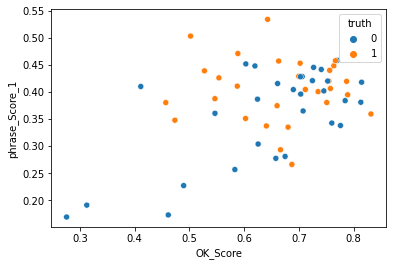

In [23]:
import seaborn as sns
p1=['disaster']
p2=['sports']
p3=['work of art']

def OK_score(text):
    test_phrase=nlp('all ok')
    doc1 = nlp(text)
    score=doc1.similarity(test_phrase)
    return score

def phrase_score(text,phrase):
    test_phrase=nlp(phrase)
    doc1 = nlp(text)
    score=doc1.similarity(test_phrase)
    return score

extract_sample=pd.DataFrame(columns=column_names)
tweetsets=[false_neg,false_pos,true_neg,true_pos]
snippet_length=15


column_names=['truth','text','OK_Score']  
full_df=pd.DataFrame(columns=column_names)
counter=0
for df_e in tweetsets:
    column_names=['truth','text','OK_Score']  
    extract_sample=pd.DataFrame(columns=column_names)
    extract_sample["set_no"]= counter
    extract_sample["id"]= df_e["id"][0:snippet_length]
    extract_sample["text"]= df_e["text"][0:snippet_length]
    extract_sample["truth"]= df_e["truth"][0:snippet_length]
    extract_sample["OK_Score"]= df_e["text"][0:snippet_length].apply(OK_score)
    extract_sample["phrase_Score_1"]= df_e["text"][0:snippet_length].apply(phrase_score, args=(p1))
    extract_sample["phrase_Score_2"]= df_e["text"][0:snippet_length].apply(phrase_score, args=(p2))
    extract_sample["phrase_Score_3"]= df_e["text"][0:snippet_length].apply(phrase_score, args=(p3))
    counter+=1
    full_df=full_df.append(extract_sample)

sns.scatterplot(data=full_df,x='OK_Score', y='phrase_Score_1',hue='truth')
#display(full_df)    




# Named Entity Recogniser
in progress

[wikitable to cv converter](https://wikitable2csv.ggor.de/)

In [18]:
from spacy import displacy

for text in false_pos['text'][1:15].apply(df_txt_cleaner):
    doc = nlp(text)
    displacy.render(doc, jupyter=True,style="ent")

/opt/conda/lib/python3.7/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [22]:
american_sports=pd.read_csv('/kaggle/input/american-sports/American_Sports.csv')
#display(american_sports.head(5))

def label_team(text,team_name):
    TN=team_name.split()
    print()
    str_startvalue=text.find(TN[1]) 
    str_endvalue=str_startvalue+len(TN[1])
    return str_startvalue,str_endvalue,df_txt_cleaner(text)

#flames example
team_ID=18
team_name=american_sports['Team'][team_ID]
print(team_name)
Flames_tweet=train_data['text'].loc[train_data['id']==762].copy()

team_train_data_list=[]
for team_name in american_sports.Team.unique():
    team_train_data_pt=list(Flames_tweet.apply(label_team,args=([team_name])))
    if team_train_data_pt[0][0]!=-1:
        team_train_data_list.append(team_train_data_pt[0])

print(team_train_data_list)
#Weird gap between printouts


    


# # Import and load the spacy model
# nlp2 = mod.load()
# # Getting the ner component
# ner=nlp2.get_pipe('ner')

# # New label to add
# LABEL = "SPORTS"

# # Training examples in the required format

# # STR="Pizza is a common fast food."
# # str_startval=0
# # str_endval=5
# # (STR, {"entities": [(str_startval, str_endval, LABEL)]})


# TRAIN_DATA =[ ("Pizza is a common fast food.", {"entities": [(0, 5, "FOOD")]})]

  

Calgary Flames



































































































































































[(16, 22, '1-6 TIX Calgary Flames vs COL Avalanche Preseason 9/29 Scotiabank Saddledome URL'), (30, 39, '1-6 TIX Calgary Flames vs COL Avalanche Preseason 9/29 Scotiabank Saddledome URL')]
